In [1]:
pip install earthengine-api


In [2]:
pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00


In [3]:
import ee
import geemap

In [4]:
ee.Authenticate
ee.Initialize

<function ee.Initialize(credentials: Optional[Any] = 'persistent', url: Optional[str] = None, cloud_api_key: Optional[str] = None, http_transport: Optional[Any] = None, project: Union[int, str, NoneType] = None) -> None>

In [5]:
    ee.Authenticate()
    ee.Initialize(project='ee-thiruvenkatesh4')

In [6]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

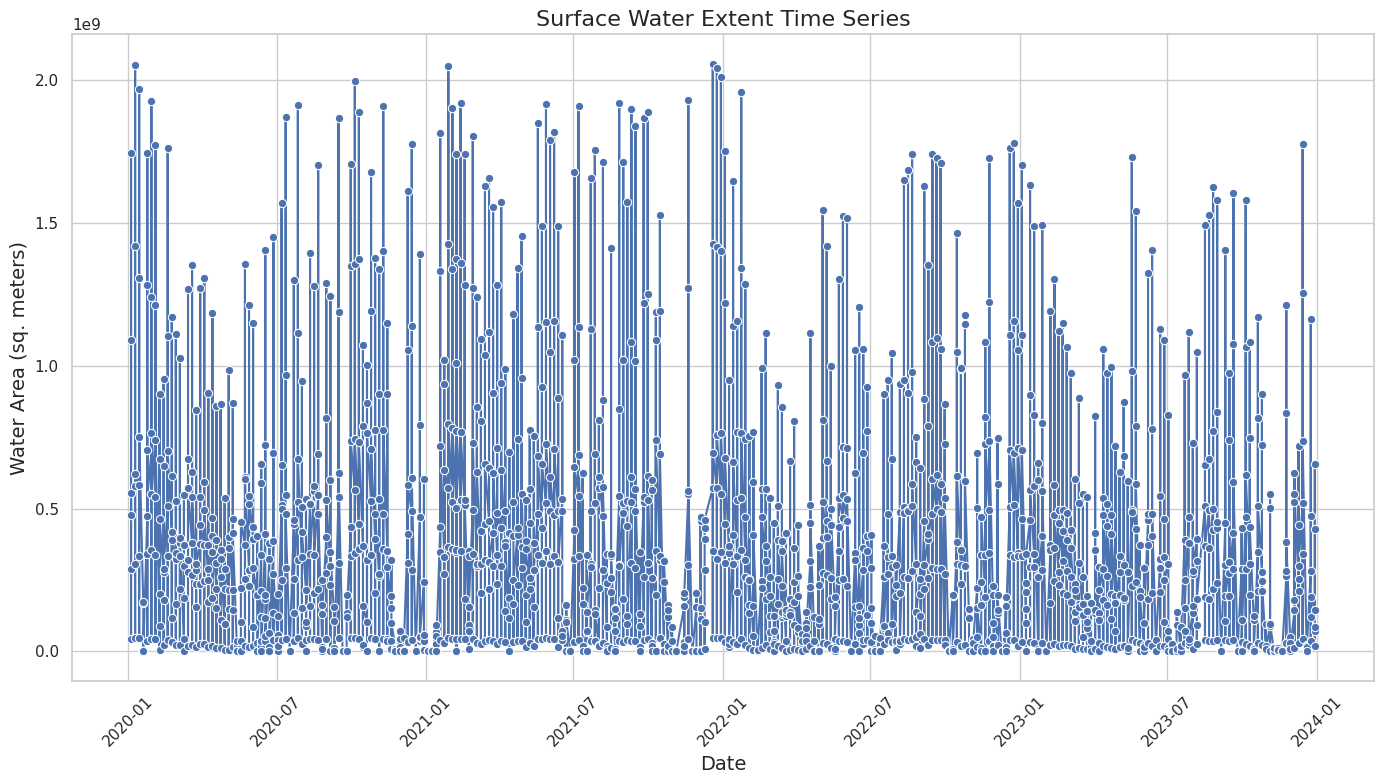

In [34]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
ee.Initialize()
def get_water_extent_time_series(geometry, start_date, end_date):
    s2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
        .filterDate(start_date, end_date)\
        .filterBounds(geometry)
    def calculate_water_area(image):
        water_mask = image.normalizedDifference(['B8', 'B4']).gt(0.25)
        water_area = water_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(), geometry=geometry, scale=10, maxPixels=1e13
        )
        return image.set('water_area', water_area.get('nd'))
    water_areas = s2_collection.map(calculate_water_area)
    water_area_list = water_areas.getInfo().get('features')
    water_area_data = [
        {'date': item['properties']['system:time_start'], 'water_area': item['properties']['water_area']}
        for item in water_area_list
    ]
    return water_area_data
water_body = ee.FeatureCollection("projects/ee-thiruvenkatesh4/assets/Madurai")
start_date = '2020-01-01'
end_date = '2024-01-01'
water_extent_data = get_water_extent_time_series(water_body, start_date, end_date)
df = pd.DataFrame(water_extent_data)
df['date'] = pd.to_datetime(df['date'], unit='ms')
sns.set(style='whitegrid')
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='date', y='water_area', marker='o', linestyle='-')
plt.title('Surface Water Extent Time Series', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Water Area (sq. meters)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('water_extent_time_series.png')
plt.show()
